# Flexibility Algo

## Algorithm to Automate Flexibility Scoring

### Import Packages

In [1]:
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from functools import reduce
import openpyxl
import xlsxwriter

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.util import ngrams
from nltk import ngrams, FreqDist
from nltk.lm import NgramCounter
import string
import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors

from spacy.lang.en.stop_words import STOP_WORDS

from collections import Counter
import itertools

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer

from nltk.cluster.kmeans import KMeansClusterer

### Put Data from Excel Sheet into Dataframes

In [2]:
# individual df's for each sheet

# when on pc
data_test_cup = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/test/semdis/autdata_test_cup_semdis.csv")
data_test_key = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/test/semdis/autdata_test_key_semdis.csv")
data_test_rope = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/test/semdis/autdata_test_rope_semdis.csv")
data_test_brick = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/test/semdis/autdata_test_brick_semdis.csv")
data_test_chair = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/test/semdis/autdata_test_chair_semdis.csv")
data_test_pencil = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/test/semdis/autdata_test_pencil_semdis.csv")
data_test_shoe = pd.read_csv("C:/Users/jhec8/Documents/Northwestern_SROP/AUT-Scoring/data/test/semdis/autdata_test_shoe_semdis.csv")

# when on mac
# data_test_cup = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/test/semdis/autdata_test_cup_semdis.csv.xlsx")
# data_test_key = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/test/semdis/autdata_test_key_semdis.csv.xlsx")
# data_test_rope = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/test/semdis/autdata_test_rope_semdis.csv.xlsx")
# data_test_brick = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/test/semdis/autdata_test_brick_semdis.csv.xlsx")
# data_test_chair = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/test/semdis/autdata_test_chair_semdis.csv.xlsx")
# data_test_pencil = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/test/semdis/autdata_test_pencil_semdis.csv.xlsx")
# data_test_shoe = pd.read_csv("/Users/johnhenrycruz/Desktop/Northwestern_SROP/AUT-Scoring/data/test/semdis/autdata_test_shoe_semdis.csv.xlsx")

### Preprocessing

In [3]:
# nltk corpus stop words
stopwords_nltk = stopwords.words('english')
# spacy stop words
stopwords_spacy = STOP_WORDS

In [4]:
stopwords_edited = list(stopwords_spacy)
stopwords_edited.append("thing")
stopwords_edited.append("things")
stopwords_edited.append("use")

In [5]:
# method to clean the responses
def process_text(text, stopwords_list, remove_sw, join_list):
    # tokenize text, lemmanize words, removing punctuation, remove stop words, lowercase all words

    # hardcorded for special situations
    text = re.sub("wedging","wedge", text)
    text = re.sub("exersizing","exercising", text)
    text = re.sub("thrown","throw", text)
    
    text = re.sub("/|-"," ", text)
    text = text.translate(str.maketrans('','',string.punctuation))
    tokens = word_tokenize(text)

    tokens = [w.lower() for w in tokens]
    
    if remove_sw:
        tokens = [word for word in tokens if word not in stopwords_list]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
#         stemmer = PorterStemmer()
#         tokens = [stemmer.stem(t) for t in tokens]

    if join_list:
        tokens = ' '.join(tokens)
 
    return tokens

### General Functions

In [6]:
# method to get a list of participants
def get_id_list(df):
    id_list = df['id'].unique()
    id_list = sorted(id_list)
    return id_list

In [7]:
# method to add a new column
# new column are cleaned responses
def get_cleaned_responses(df, stopwords_list, remove_sw, join_list):
    # id_df = df[df.id == id]
    df_processed = df.copy(deep=True)
    responses = df['response'].tolist()

    # make list of processed responses
    for response in range(len(responses)):
        responses[response] = process_text(responses[response], stopwords_list, remove_sw, join_list)

    # add list as column in df
    df_processed['response_processed'] = responses

    return df_processed

### Word2Vec Models for Embeddings

In [8]:
# load pretrained model
word_model_twitter25 = api.load("glove-twitter-25")

# on pc
# word_model_google = KeyedVectors.load_word2vec_format("C:/Users/jhec8/Documents/Northwestern_SROP/GoogleNews-vectors-negative300.bin", binary=True)

# on mac
# word_model = KeyedVectors.load_word2vec_format("/Users/johnhenrycruz/Desktop/Northwestern_SROP/GoogleNews-vectors-negative300.bin", binary=True)

In [9]:
# create dictionary of counts for each word in model
twitter25_dict = {}
for i in range(len(word_model_twitter25)):
    twitter25_dict[word_model_twitter25.index_to_key[i]] = word_model_twitter25.key_to_index[word_model_twitter25.index_to_key[i]]

In [10]:
# get the frequency of each word in dictionary
total_words = 0
for key in twitter25_dict:
    total_words = total_words + twitter25_dict[key]
    
for key in twitter25_dict:
    twitter25_dict[key] = twitter25_dict[key]/total_words

## Flexibility Algo 1
### tf-idf scikit-learn + clustering
### ___ as document

In [11]:
def get_tfidf_vector(num_clusters, responses):
    # initialize CountVectorizer object
    tfidf_vectorizer = TfidfVectorizer(use_idf=True)
    # vectorize the phrases
    tfidf = tfidf_vectorizer.fit_transform(responses)
    
    
    # elbow method to visualize and find out how many clusters to use
    visualizer = KElbowVisualizer(KMeans(), k=(1,12), timings=False)
    visualizer.fit(tfidf.toarray())       
    visualizer.show()

    # nltk kmeans cosine distance implementation
    number_of_clusters = num_clusters
    kmeans = KMeansClusterer(number_of_clusters, distance=nltk.cluster.util.cosine_distance, repeats=25, avoid_empty_clusters=True)
    assigned_clusters = kmeans.cluster(tfidf.toarray(), assign_clusters=True)

#     scikit-learn euclidean distance implementation
#     kmeans = KMeans(n_clusters = num_clusters).fit(tfidf)
        
    # cluster results scikit-learn
    results = pd.DataFrame()
    results['text'] = responses
#     results['category'] = kmeans.labels_
    results['category'] = assigned_clusters
    
    # create dictionary to organize the clusters with their respective phrases
    results_dict = {k: g["text"].tolist() for k,g in results.groupby("category")}
    
    # df of the clusters and the 
    clusters_df = pd.DataFrame(list(results_dict.items()),columns = ['category','responses']) 
    
    # uncomment to see clusters 
    display(clusters_df)
    
    return clusters_df

In [12]:
def get_flexibility_tfidf_scikit_learn_clustering(df, stopwords_list, num_clusters, remove_sw, join_list):
    flexibility_rating_df = get_cleaned_responses(df, stopwords_list, remove_sw, join_list)
    responses_split = flexibility_rating_df['response_processed'].tolist()
    responses = []
    
    id_list = get_id_list(df)
    
    for participant in id_list:
        temp_df = flexibility_rating_df.loc[flexibility_rating_df['id'] == participant]
        temp_list = temp_df['response_processed'].tolist()
        temp_list = ' '.join(temp_list)
        responses.append(temp_list)
                
    clusters_df = get_tfidf_vector(num_clusters, responses_split)

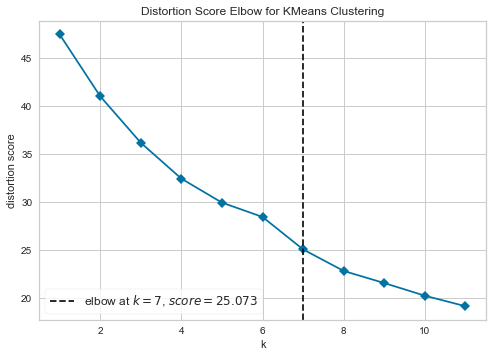

,category,responses
0,0,"[paperweight, paperweight, paperweight, paperw..."
1,1,"[weapon, weapon, weapon, weapon, weapon]"
2,2,"[build, build, build, build, build]"
3,3,"[throw demolish, throw weapon, throw, throw]"
4,4,"[break window, break window, break]"
5,5,"[foundation, bowl, line fireplace, line road, ..."
6,6,"[build house, build house, house, build house,..."
7,7,"[weight workout, weight holding wind, weight, ..."
8,8,[break prop martial art]


In [13]:
get_flexibility_tfidf_scikit_learn_clustering(data_test_brick, stopwords_edited, 9, True, True)

### Write Results into Excel Sheet

In [14]:
prompts_list = ['cup', 'key', 'rope', 'brick', 'chair', 'pencil', 'shoe']
data_list = [data_test_cup, data_test_key, data_test_rope, data_test_brick, data_test_chair, data_test_pencil, data_test_shoe]

In [15]:
# write results df of each dataset for specific methods
def write_results_excel(method, stopwords, remove_sw, join_list):
    # change this when writing new sheet
    writer = pd.ExcelWriter('originality_cv_freq_cluster_results.xlsx', engine='xlsxwriter')

    for i in range(len(prompts_list)):
        df = method(data_list[i], stopwords, remove_sw, join_list)
        df.to_excel(writer, sheet_name = prompts_list[i], index = False)
    writer.save()

In [16]:
# write_results_excel(get_originality_count_vectorizer, stopwords_spacy, True, True)

Algo Design Brainstorming:

To Do List
- [ ] brainstorm strategy
